# Import neccessary packages

In [1]:
import scipy.io as sio

import pickle

import numpy as np  

import os

import matplotlib.pyplot as plt

import matplotlib.pylab as pylab

import random

from scipy.special import logsumexp

from scipy.stats import norm

from numpy.polynomial.polynomial import polyvander

# Import data from file

In [2]:
# Import data
#os.chdir('/Users/xuxing/desktop')
os.chdir('/Users/Lai/Dropbox/CS/sherrie/A4')
data = sio.loadmat('data4.mat')
dataX = np.array(data['X'])
dataY = np.array(data['Y'])[:, 0]
data_labels = np.array(data['Z'])[:, 0]  

# 0 missing labels, 1 is class 1, 2 is class 2
np.random.seed(14)



# Helper functions

In [3]:
def log_factorial_approximation(Y):
    '''
    np.log(Y!) = np.log(1) + np.log(2) + ..... +np.log(Y) for numerical stability
    '''    
    if type(Y) is not np.ndarray:
        result = 0
        for i in range(int(Y), 0, -1):
            result += np.log(i)
        return result
    result = np.zeros(Y.shape[0])
    for i in range(Y.shape[0]):
        for j in range(int(Y[i][0]),0,-1):
            result[i] += np.log(j)
    return result.reshape(-1,1)

In [4]:
def log_Poisson(log_lambda,Y):
    '''
    Keep in the log space for numerical stability
    '''
    result = -np.exp(log_lambda) + Y * log_lambda - log_factorial_approximation(Y) # Poisson density function
    
    return result

In [5]:
def basis_func(x,Dim,p):
    '''
    For each dimension of input X, expand to 1 + x + x^2 + x^3 + ... x^p for mononial basis functions with polynomial degree p
    '''
    result = np.zeros((N,Dim*p+1))
    for d in range(Dim):
        for i in range(p):
            result[:,d*p+i+1] = x[:,d]**(i+1)
    result[:,0] += np.ones(N)
    
    return result

In [6]:
def log_lambda_update(X,beta):
    '''
    Compute log lambda given current beta
    '''
    return np.dot(X,beta)

In [7]:
def objective_func(Z, Y, log_lambda,alpha):
    '''
    For each iteration in M-step, we maximize this log-likelihood with current responsibility probability
    Use it for debug
    '''
    log_f = log_Poisson(log_lambda,Y.reshape(-1,1))
    return np.mean(Z*log_f + Z*alpha)

In [8]:
def add_noise_data(C,labels,x,y):
    '''
    Usually don't call this function unless we believe that the data set consists of more num of clusters than the
    number of labels we current have
    '''

    xmean = np.mean(x,axis=0)
    xvar = np.var(x,axis=0)

    _lambda = np.mean(y)

    noisex = np.random.multivariate_normal(xmean,np.diag(xvar),C) # random sample some data from multivariate normal distribution
    noisey = np.random.poisson(_lambda,C)

    X = np.concatenate((x, noisex), axis=0)
    Y = np.concatenate((y, noisey), axis=0)

    lab = np.concatenate((labels,np.arange(C+1)),axis=0)

    return X,Y,lab

# Algorithm

In [9]:
def init_params(X,Y,labels):
    '''
    Initial guess for Z which is responsibility matrix with dimension NxC
    Where C is the number of clusters that we believe 
    '''
    
    # guess our responsibility
    Z = np.zeros((N,C))
    for i in range(N):
        if labels[i] != 0:
            if (int(labels[i])) >= Z.shape[1]: # if we believe that true number of C is less than num of unique labels
                Z[i][np.random.randint(C)] = 1
            else:
                Z[i][int(labels[i])-1] = 1
        else:
            Z[i][np.random.randint(C)] = 1

    
    indx = np.where(Y != 0)[0]
    vdataY = Y[indx]
    log_lambda = np.zeros((N, C))

    # update our log_lambda based on naive guess
    for c in range(C):
        log_lambda[:, c] = np.mean(np.log(vdataY[np.where(Z[indx,c] == 1)[0]], dtype='f'))

    beta,gamma,log_lambda,W = Gradient_Ascent(Y.reshape(-1, 1), log_lambda, X, Z,0.2)

    return beta, Z

In [10]:
def Expectation(alpha,log_lambda,Y,labels):
    '''
    E-Step: Update the responsibility matrix z
    For data with known labels, do not update the responsibilities
    For data with unknown labels, update to new responsibilities based on Bayes' rule
    
    Always keep in log space for numerical safety
    '''
    log_proportion = np.log(alpha)
    results = np.zeros((N,C))

    for i in range(N):
        if labels[i] != 0 and int(labels[i])-1 < C:
            results[i][int(labels[i])-1] = 1
        else:
            log_poisson_dist = log_Poisson(log_lambda[i,:], Y[i])
            nume = log_proportion + log_poisson_dist
            deno = logsumexp(nume)
            results[i,:] = np.exp(nume - deno)
            
    return results

In [11]:
def Gradient_Ascent(Y, log_lambda, X, Z,learning_rate):
    '''
    Gradient Ascend to approximate optimal lambda for updating beta
    '''
    for i in range(20):
        temp = Z * np.exp(log_lambda)
        W = np.zeros((C, N, N))
        for c in range(C):
            W[c] = np.diag(temp[:, c])

        gamma = np.zeros((N, C))
        for i in range(0, C):
            gamma = log_lambda + (Y.reshape(-1, 1) - np.exp(log_lambda)) / np.exp(log_lambda) * learning_rate
            
        # Using SVD method to solve for beta    
        beta = np.zeros((D * P + 1, C))
        for i in range(0, C):
            U, Omega, V = np.linalg.svd(np.dot(W[i] ** 0.5, X), full_matrices=0)
            beta[:, i] = np.dot(np.dot(V.T,np.linalg.inv(np.diag(Omega))), U.T.dot(np.dot(W[i] ** 0.5, gamma[:, i].T)))

        # update log(lambda)
        log_lambda = log_lambda_update(X, beta)

    return beta, gamma, log_lambda, W

In [12]:
def Optimization(x,X, y, labels,iters,learning_rate):
    '''
    Use EM algorithm to run enough iterations and check for converge
    '''
    # Initial step
    likelihood = []
    beta, Z = init_params(X,y,labels)
    alpha = np.sum(Z, axis=0) / N
    
    # Running iterations
    for i in range(iters):
        
        # Update log_lambda
        log_lambda = log_lambda_update(X, beta)
        
        # Update beta, gamma, log_lambda and W
        beta, gamma, log_lambda, W = Gradient_Ascent(y.reshape(-1, 1), log_lambda, X, Z,learning_rate)

        # Update Z
        Z = Expectation(alpha, log_lambda, y, labels)
        
        # Update alpha
        alpha = np.sum(Z, axis=0) / N
        
        # Check likelihood for debug
        likelihood.append(objective_func(Z, y, log_lambda, alpha))
        
        # Print statement
        if i%5 == 0:
            print("EM {}th Iteration".format(i))
            
    # Plots for visiualization
    plt.plot(likelihood)
    plt.show()
    visualizer(x, X, y,labels, Z, beta, log_lambda, P, C)
    
    
    return beta, Z, log_lambda, alpha,likelihood,W

# Results & Visualization

In [13]:
def visualizer(x,X,Y,labels,Z,beta,log_lambda,P,C):

    Y = Y[np.where(Y!=0)[0]]
    X= X[np.where(Y!=0)[0]]
    x = x[np.where(Y != 0)[0]]
    Z = Z[np.where(Y!=0)[0]]
    inx = np.argmax(Z,axis=1)
    label_inx = []

    # get index for each labels
    for i in np.unique(labels):
        I = np.where(labels==i)[0]
        label_inx.append(I)

    for c in range(C):
        
        # data that clustered into this group
        c_inx = np.where(inx==c)[0]
        x_c = X[c_inx]
        if x_c.shape[0] == 0: # if there is any data clustered in this Group
            print("Algorithm Believe that There is No Data Point Belongs to Cluster{}".format(c))
        else:
            for d in range(D):
                xx = np.linspace(np.min(x[:, d], axis=0) * 1.1, np.max(x[:, d], axis=0) * 1.1, 10000)
                XX = np.delete(polyvander(xx,P),0,1)

                for i in label_inx:
                    if len(x[np.intersect1d(c_inx,i)])>0:
                    # get data clustered into group c but with labels i
                        inx_ci = np.intersect1d(c_inx, i)
                        residual = log_lambda[inx_ci, c] - beta[0][c]
                        #residual = np.log(Y[inx_ci]) - beta[0][c]
                        for k in range(D):
                            residual = residual - (d != k) * np.dot(X[inx_ci][:, k * P + 1:(k + 1) * P + 1],
                                                                    beta[:, c][k * P + 1:(k + 1) * P + 1])
                        if labels[i[0]] == 0:
                            leg = "Missing Label"
                        else:
                            leg = "label {}".format(labels[i[0]])
                        plt.scatter(x[inx_ci][:,d],residual,label = leg)
                        
                # Plots        
                plt.xlabel("x{}".format(d+1))
                plt.ylabel("residual")
                plt.title("The Data clustered in {} group".format(c+1))
                plt.plot(xx, np.dot(XX, beta[:,c][d * P + 1:(d + 1) * P + 1]), 'r')
                plt.legend()
                plt.show()
                


def residual(x,beta,log_lambda,y,X,labels,Z,W,alpha):
    '''
    Residual plot to evaluate the model performance when doing cross validation
    '''
    y = y[np.where(y!=0)[0]]
    X= X[np.where(y!=0)[0]]
    x= x[np.where(y!=0)[0]]
    Z = Z[np.where(y!=0)[0]]
    labels = labels[np.where(y!=0)[0]]
    inx = np.argmax(Z,axis=1)
    label_inx = []

    # get index for each labels
    for i in np.unique(labels):
        I = np.where(labels==i)[0]
        label_inx.append(I)

    sum_res = 0
    for c in range(C):
        c_inx = np.where(inx==c)[0]
        x_c = X[c_inx]
        for i in label_inx:
            if len(X[np.intersect1d(c_inx,i)])>0:
                inx_ci = np.intersect1d(c_inx, i)
                pred = beta[0][c]
                for k in range(D):
                    pred += np.dot(X[inx_ci][:, k * P + 1:(k + 1) * P + 1],
                                   beta[:, c][k * P + 1:(k + 1) * P + 1])
            residual = np.log(y[inx_ci]) - pred
            wgt_res = W[c][inx_ci,inx_ci]*(residual)**2
            lik = objective_func(Z[inx_ci], y[inx_ci], log_lambda[inx_ci],alpha)
            for j in range(1,D):
                plt.xlabel("x{}".format(j+1))
                plt.ylabel("Residual")
                plt.title("The Residuals of Data clustered in {} group".format(c+1))
                #plt.scatter(X[inx_ci,j],residual)
                plt.scatter(y[inx_ci],residual)
                plt.show()
        sum_res += np.sum(wgt_res)
  
    return lik

# Train with given data

EM 0th Iteration
EM 5th Iteration
EM 10th Iteration
EM 15th Iteration
EM 20th Iteration
EM 25th Iteration
EM 30th Iteration
EM 35th Iteration


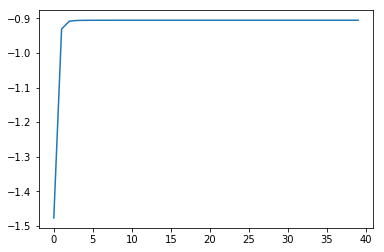

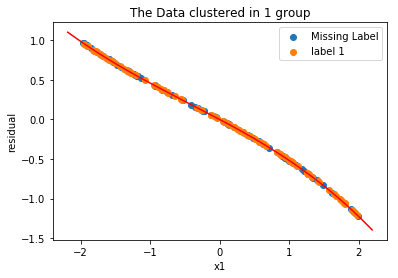

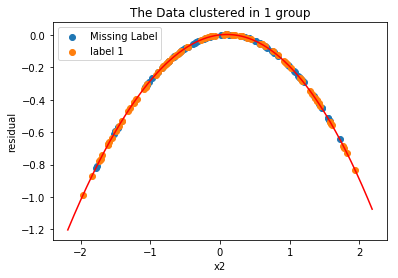

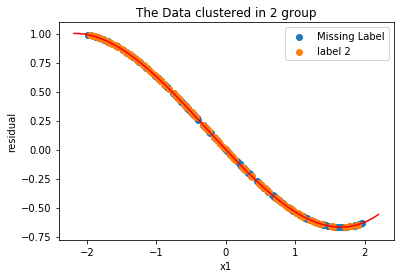

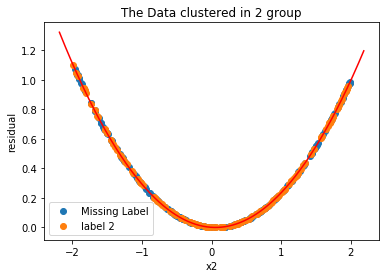

EM 0th Iteration
EM 5th Iteration
EM 10th Iteration
EM 15th Iteration
EM 20th Iteration
EM 25th Iteration
EM 30th Iteration
EM 35th Iteration


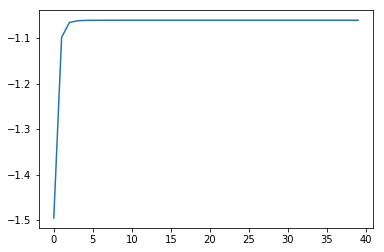

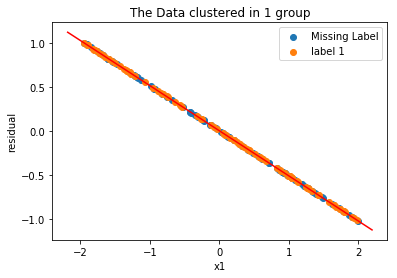

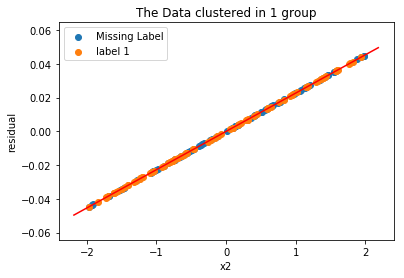

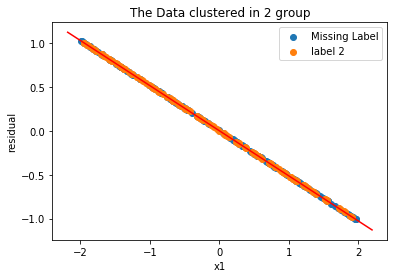

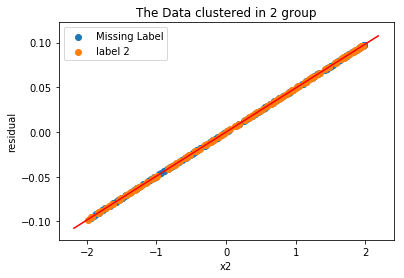

____________P = 1, C = 2__________Residual Plot


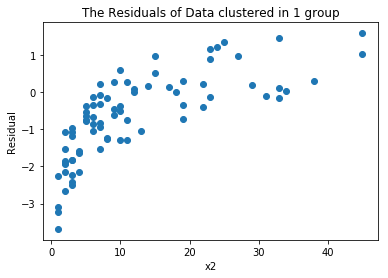

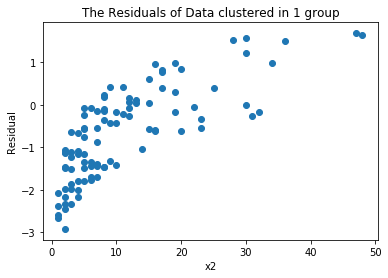

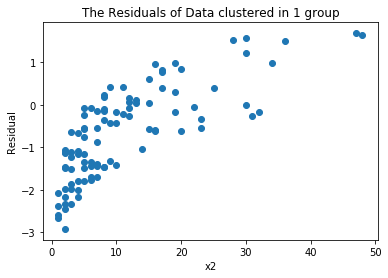

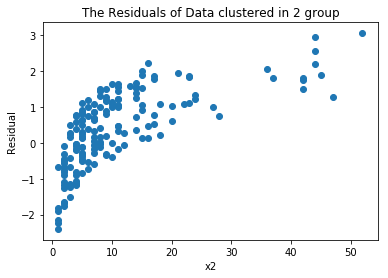

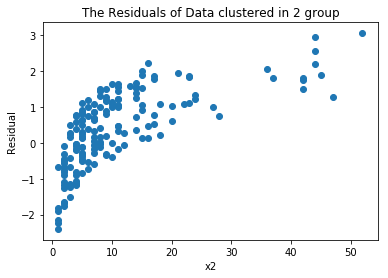

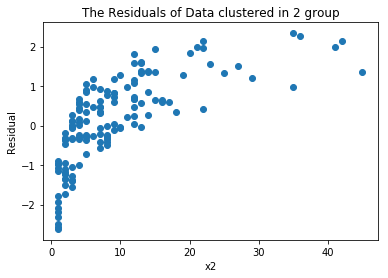

EM 0th Iteration
EM 5th Iteration
EM 10th Iteration
EM 15th Iteration
EM 20th Iteration
EM 25th Iteration
EM 30th Iteration
EM 35th Iteration


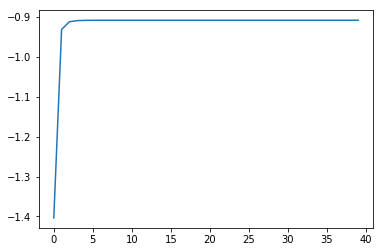

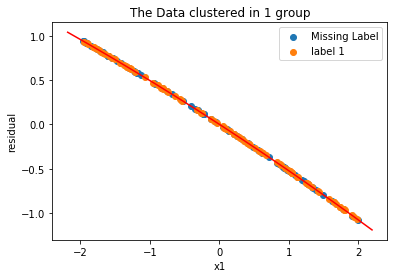

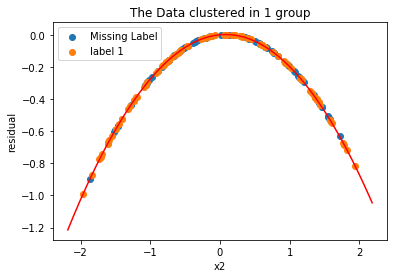

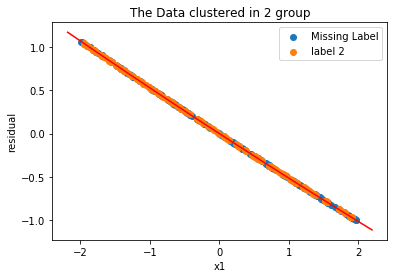

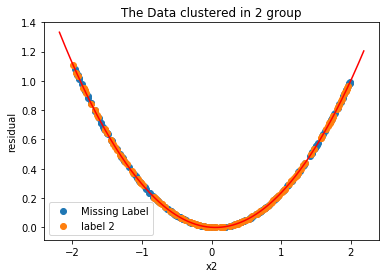

____________P = 2, C = 2__________Residual Plot


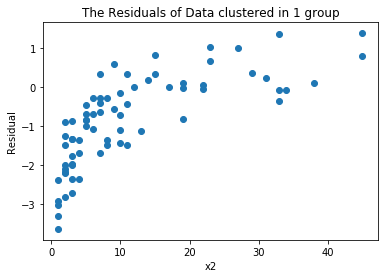

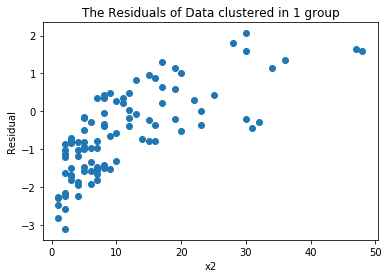

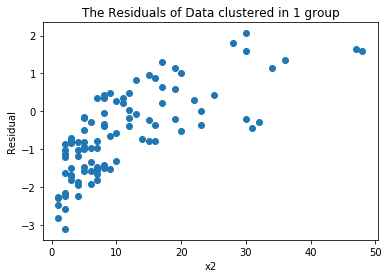

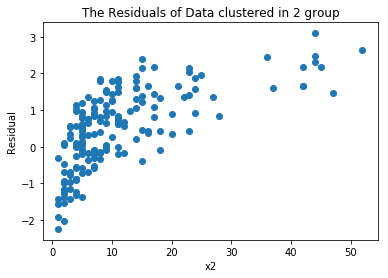

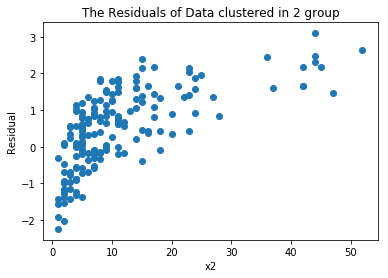

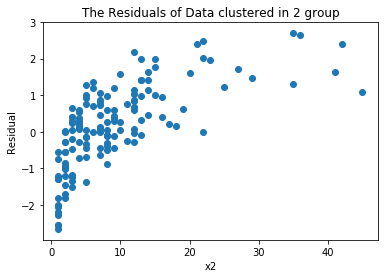

EM 0th Iteration
EM 5th Iteration
EM 10th Iteration
EM 15th Iteration
EM 20th Iteration
EM 25th Iteration
EM 30th Iteration
EM 35th Iteration


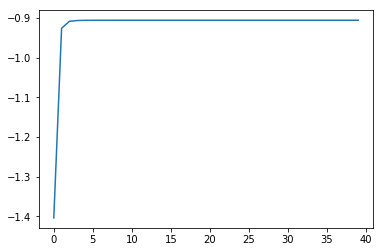

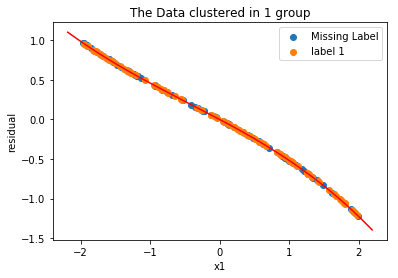

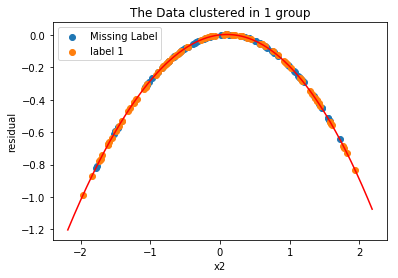

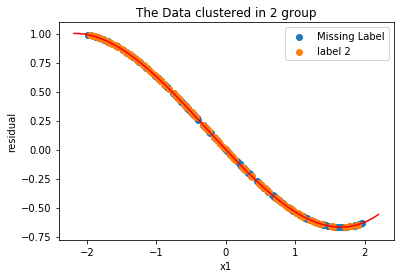

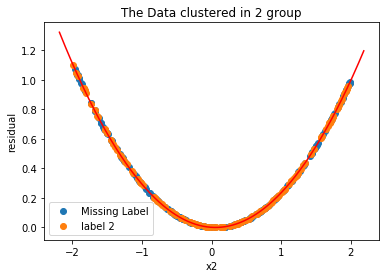

____________P = 3, C = 2__________Residual Plot


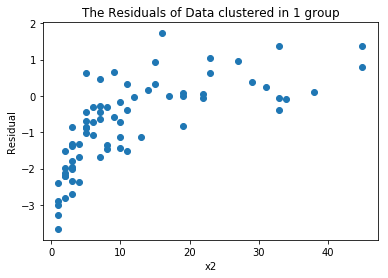

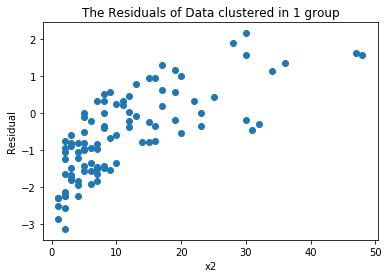

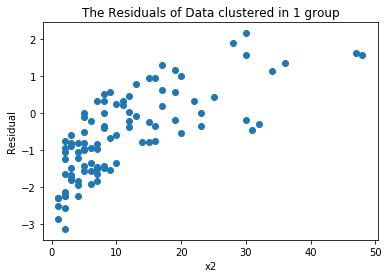

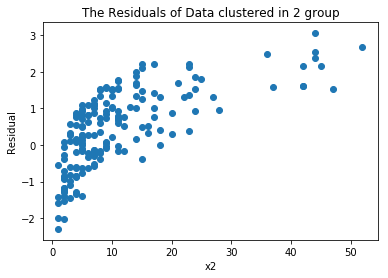

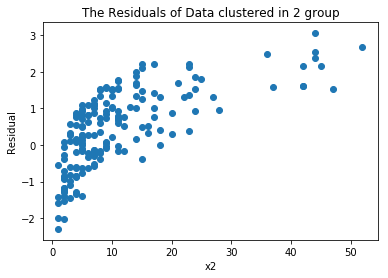

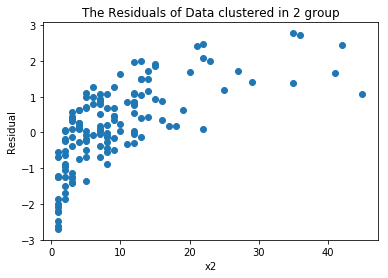

EM 0th Iteration
EM 5th Iteration
EM 10th Iteration
EM 15th Iteration
EM 20th Iteration
EM 25th Iteration
EM 30th Iteration
EM 35th Iteration


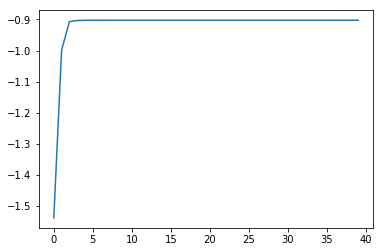

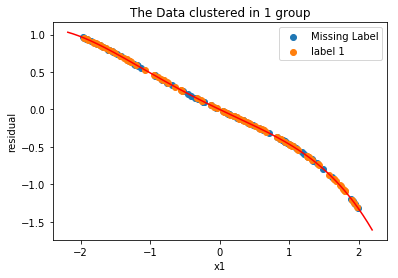

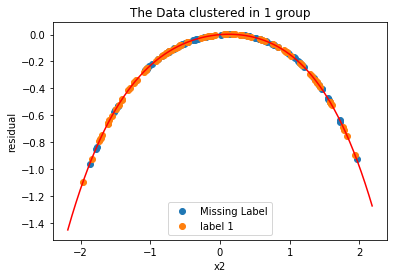

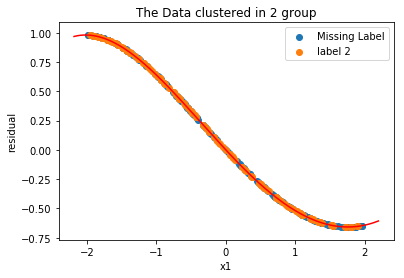

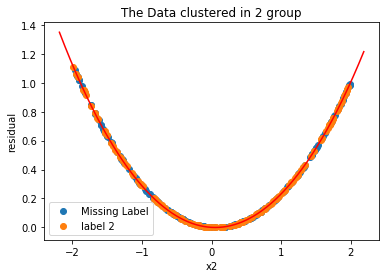

____________P = 4, C = 2__________Residual Plot


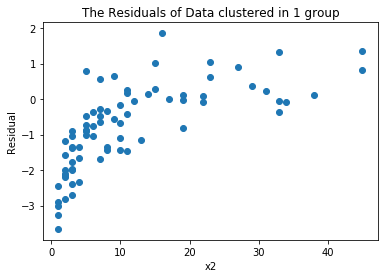

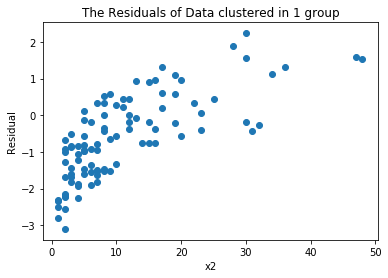

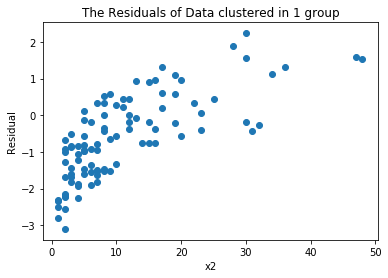

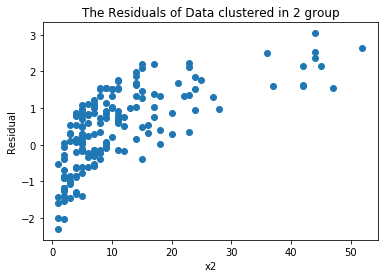

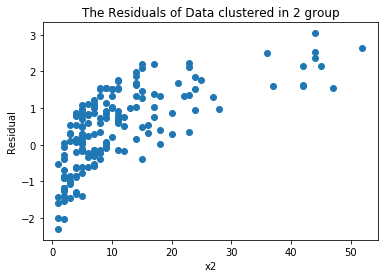

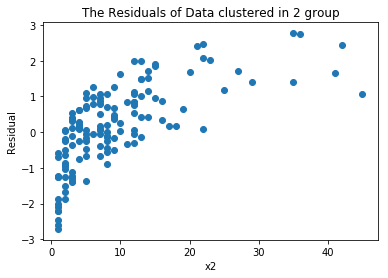

EM 0th Iteration
EM 5th Iteration
EM 10th Iteration
EM 15th Iteration
EM 20th Iteration
EM 25th Iteration
EM 30th Iteration
EM 35th Iteration


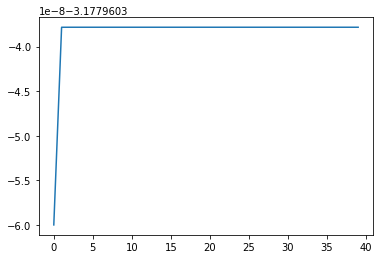

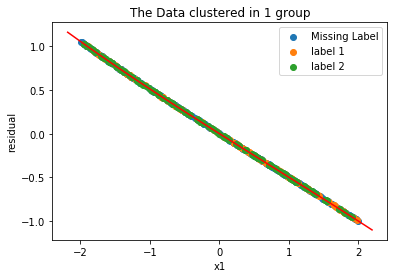

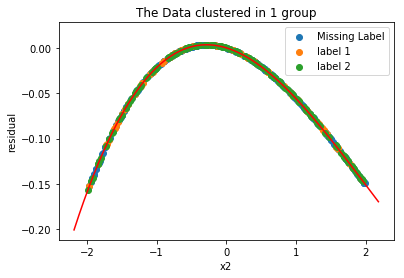

____________P = 3, C = 1__________Residual Plot


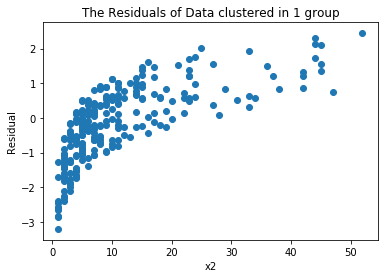

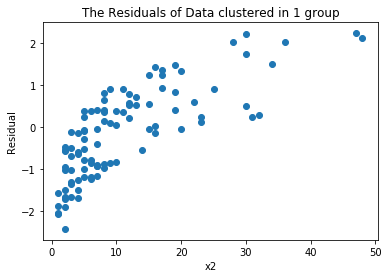

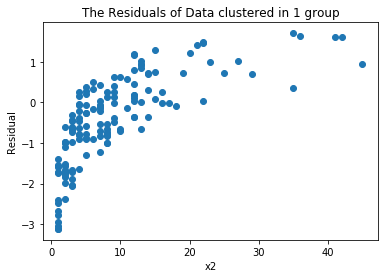

EM 0th Iteration
EM 5th Iteration
EM 10th Iteration
EM 15th Iteration
EM 20th Iteration
EM 25th Iteration
EM 30th Iteration
EM 35th Iteration


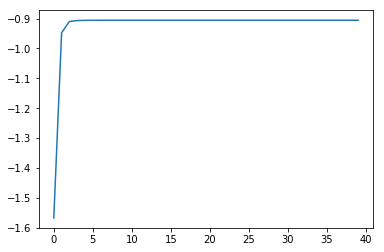

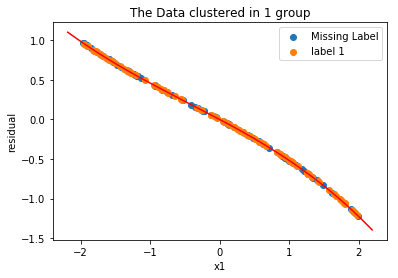

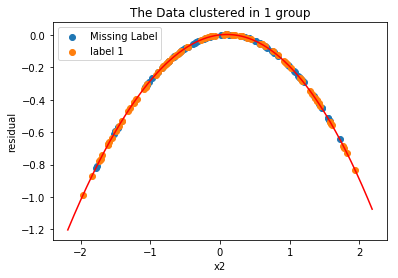

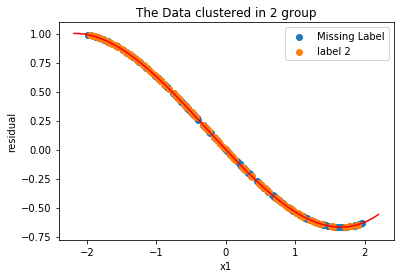

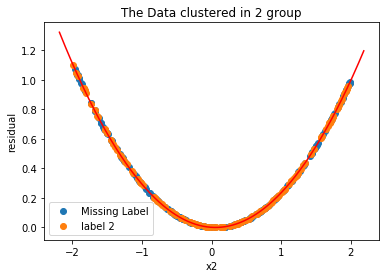

____________P = 3, C = 2__________Residual Plot


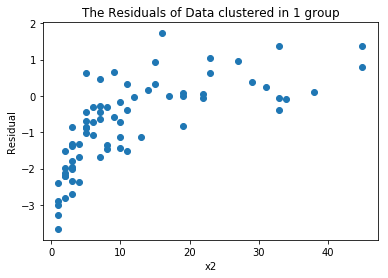

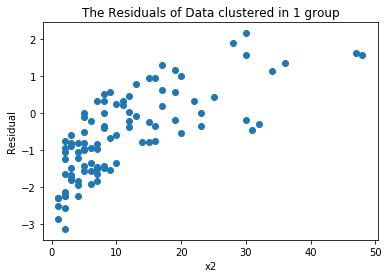

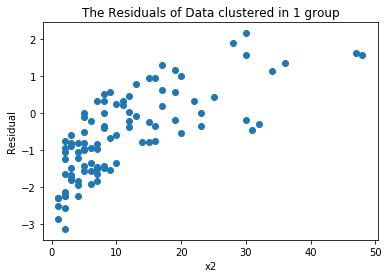

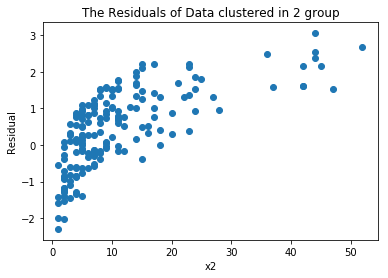

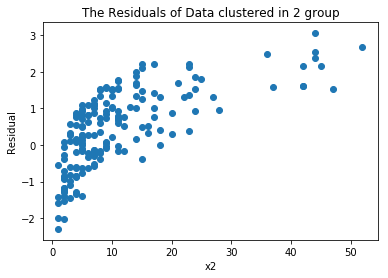

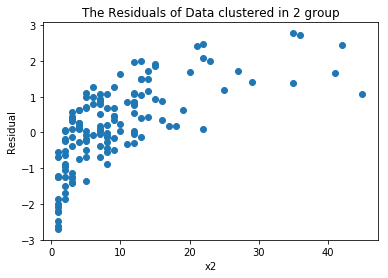

EM 0th Iteration
EM 5th Iteration
EM 10th Iteration
EM 15th Iteration
EM 20th Iteration
EM 25th Iteration
EM 30th Iteration
EM 35th Iteration


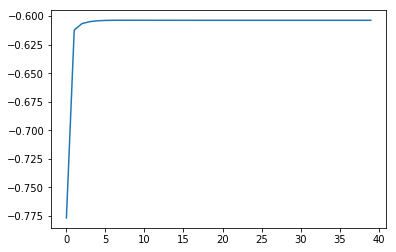

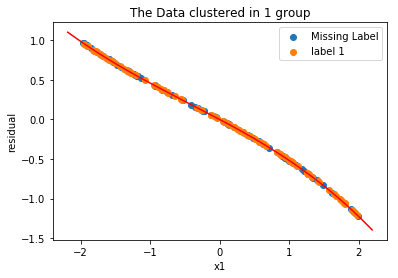

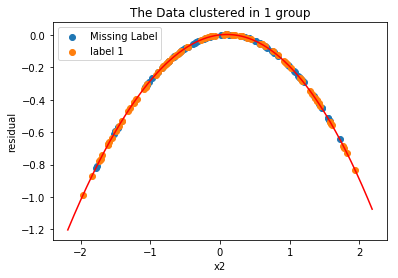

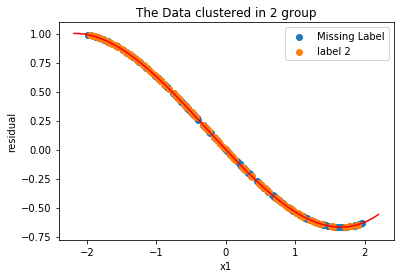

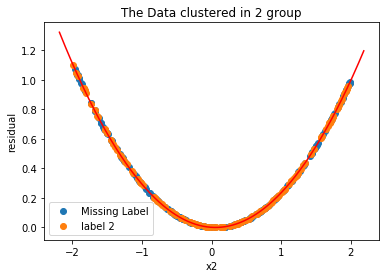

Algorithm Believe that There is No Data Point Belongs to Cluster2
____________P = 3, C = 3__________Residual Plot


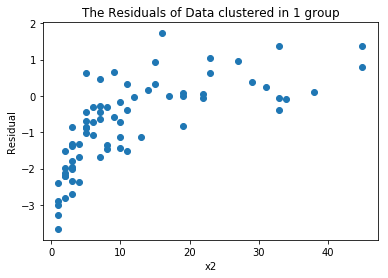

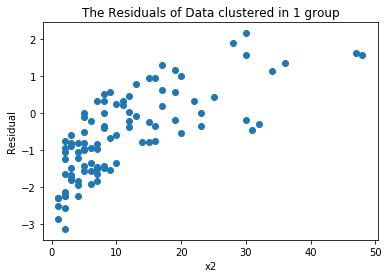

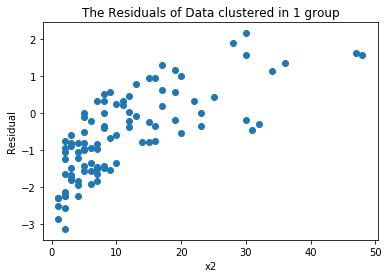

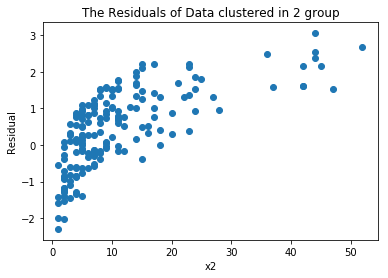

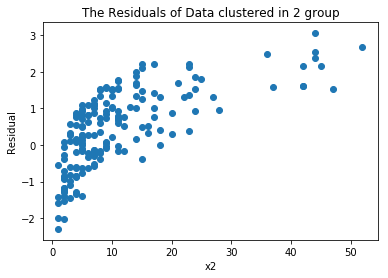

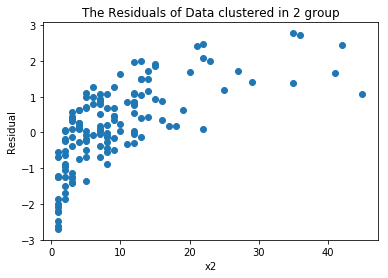

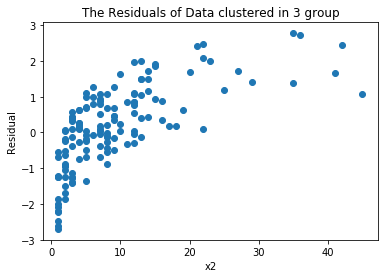

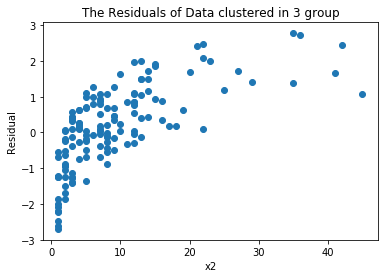

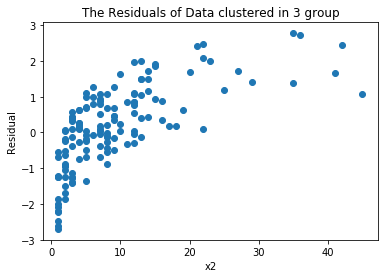

EM 0th Iteration
EM 5th Iteration
EM 10th Iteration
EM 15th Iteration
EM 20th Iteration
EM 25th Iteration
EM 30th Iteration
EM 35th Iteration


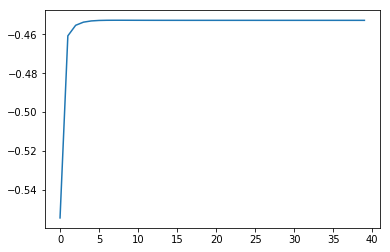

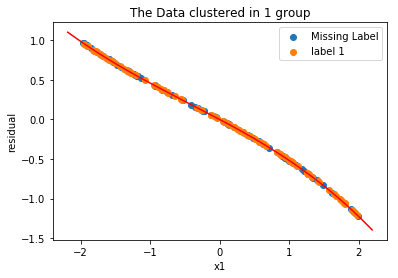

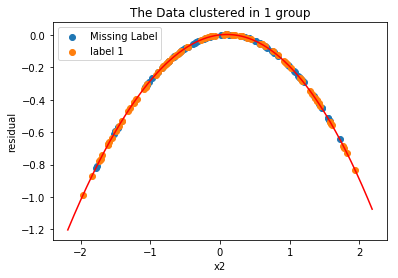

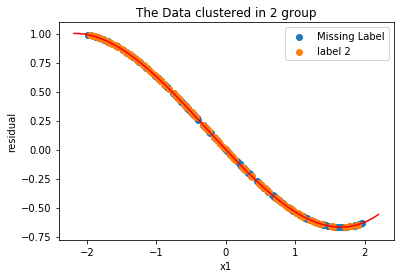

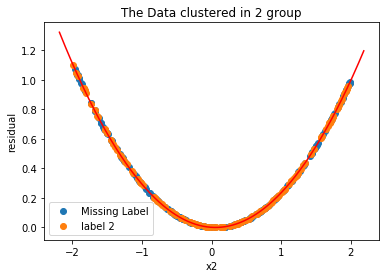

Algorithm Believe that There is No Data Point Belongs to Cluster2
Algorithm Believe that There is No Data Point Belongs to Cluster3
____________P = 3, C = 4__________Residual Plot


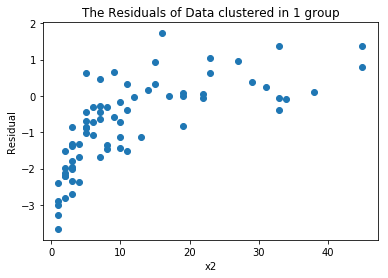

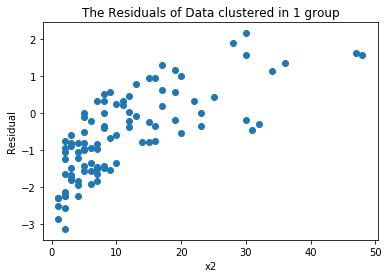

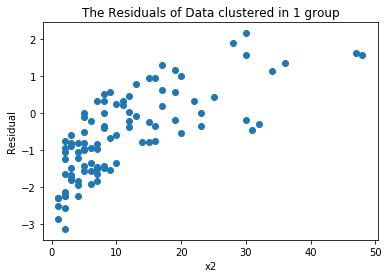

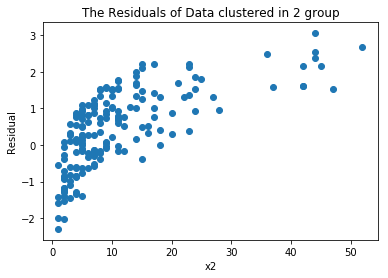

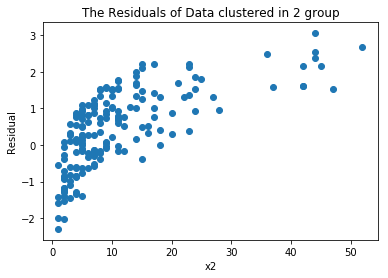

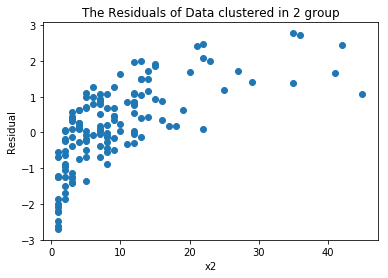

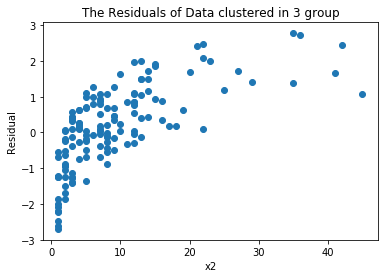

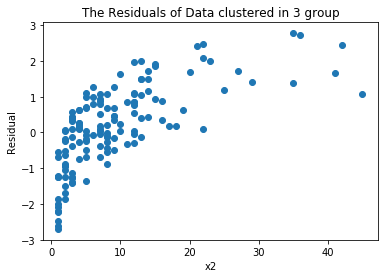

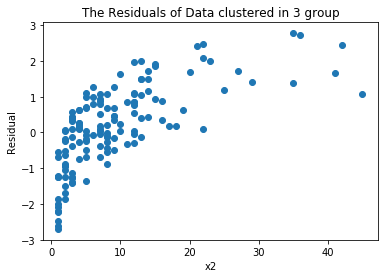

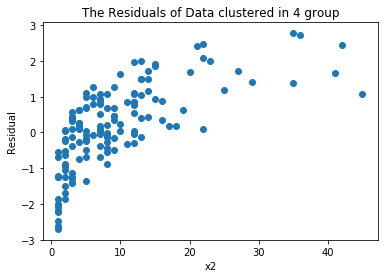

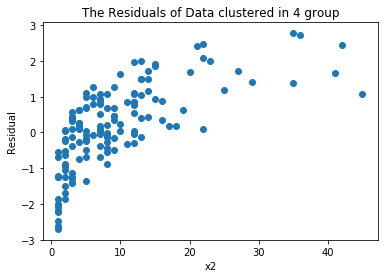

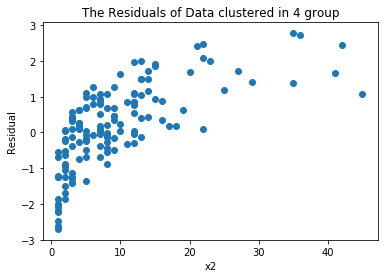

In [14]:
N = dataX.shape[0]
D = dataX.shape[1]
C = 2
P = 3
X = basis_func(dataX,D,P)
beta, Z, log_lambda,alpha,likelihood,W = Optimization(dataX,X,dataY, data_labels, 40,0.2)



# This is made for cross validation

mol_val = []
for p in [1,2,3,4]:
    P = p
    X = basis_func(dataX,D,P)
    beta, Z, log_lambda,alpha,likelihood,W = Optimization(dataX,X,dataY, data_labels, 40,0.2)
    print("____________P = {}, C = {}__________Residual Plot".format(P,C))
    res = residual(dataX,beta,log_lambda,dataY,X,data_labels,Z,W,alpha)
    mol_val.append(res)
    opt_p = np.argmin(mol_val) + 1
    
mol_val = []
for c in [1,2,3,4]:
    C = c
    P = opt_p
    X = basis_func(dataX,D,P)
    beta, Z, log_lambda,alpha,likelihood,W = Optimization(dataX,X,dataY, data_labels, 40,0.2)
    print("____________P = {}, C = {}__________Residual Plot".format(P,C))
    res = residual(dataX,beta,log_lambda,dataY,X,data_labels,Z,W,alpha)
    mol_val.append(res)
    opt_c = np.argmin(mol_val) + 1

# Simulator

In [15]:


def Func_Sim(num):
    
    label = np.zeros(num)
    ans = np.zeros(num)

    x1 = np.random.uniform(-5, 5, (int(num/3), 2))
    f_11 = 1 / (1 + np.exp(-x1[:, 1]))  # logistic function
    f_12 = np.cos(x1[:, 0]) + 2  #
    y1 = f_11 + f_12 ** 2 + np.random.normal(0, 1, int(num/3)) ** 2

    y1 = np.random.poisson(abs(y1))

    indx = random.sample(range(x1.shape[0]), int(x1.shape[0]/3))
    label[indx] = 1
    ans[:int(num/3)] = 1

    x2 = np.random.uniform(-3, 7, (int(num/3), 2))
    f_21 = np.sqrt(49-x2[:,0]**2)
    f_22 = np.log(abs(x2[:,1]))
    y2 = f_21 + f_22 + np.random.uniform(0, 1, int(num/3))**2

    y2 = np.random.poisson(abs(y2))
    indx = random.sample(range(int(num/3),int(num/3)+x1.shape[0]), int(x1.shape[0]/3))
    label[indx] = 2
    ans[int(num/3):int(num/3)+x1.shape[0]] = 2

    x3 = np.random.uniform(-7, 3, (int(num/3)+1, 2))
    f_31 = norm.pdf((x3[:, 0] + 5)) * 7
    f_32 = norm.pdf((x3[:, 1] + 2)) * 2
    y3 = 0.3*f_31 + 0.7*f_32

    y3 = np.random.poisson(abs(y3))
    indx = random.sample(range(int(num/3)*2,int(num/3)*2+x1.shape[0]), int(x1.shape[0]/3))
    label[indx] = 3
    ans[int(num/3)*2:int(num/3)*2+x1.shape[0]+1] = 3

    simX = np.concatenate((np.concatenate((x1, x2), axis=0), x3), axis=0)
    simY = np.concatenate((np.concatenate((y1, y2), axis=0), y3), axis=0)

    return simX,simY,label,ans

# Visualize the simulated data

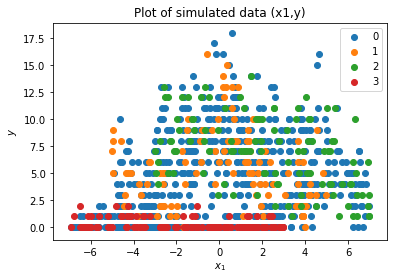

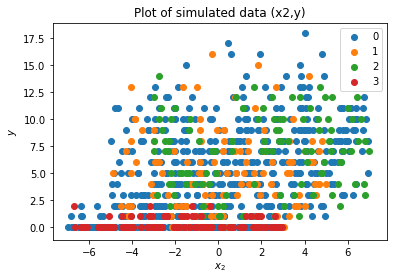

In [16]:
simX,simY,simLabels,ans = Func_Sim(1000)


for i in range(4):
    plt.scatter(simX[simLabels == i, 0], simY[simLabels == i], label = i)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$y$')
plt.title('Plot of simulated data (x1,y)')
plt.legend()
plt.show()

for i in range(4):
    plt.scatter(simX[simLabels == i, 1], simY[simLabels == i], label=i)
plt.xlabel(r'$x_2$')
plt.ylabel(r'$y$')
plt.title('Plot of simulated data (x2,y)')
plt.legend()
plt.show()

idx = np.random.permutation(simY.shape[0])
simX,simY,simLabels,ans = simX[idx,:], simY[idx],simLabels[idx],ans[idx]
simY[np.sign(simY)!=1] = 1

simData = (simX,simY,simLabels)
with open("simData", "wb") as handle:
    pickle.dump(simData,handle, protocol=pickle.HIGHEST_PROTOCOL)

In [17]:
# Define global variable for simulator
# Add noise data to it

P=5
C=3
D=2
#simX,simY,simLabels = add_noise_data(C,simLabels,simX,simY)
#N=1000 + C
N=1000
simX_ = basis_func(simX,D,P)

EM 0th Iteration
EM 5th Iteration
EM 10th Iteration
EM 15th Iteration
EM 20th Iteration
EM 25th Iteration
EM 30th Iteration
EM 35th Iteration


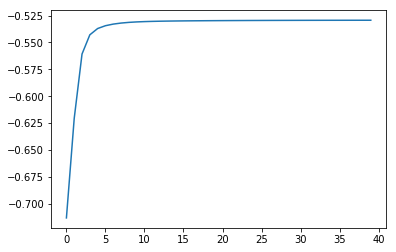

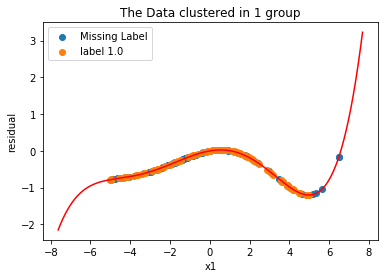

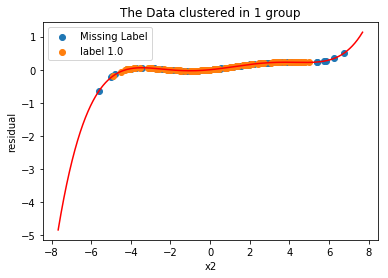

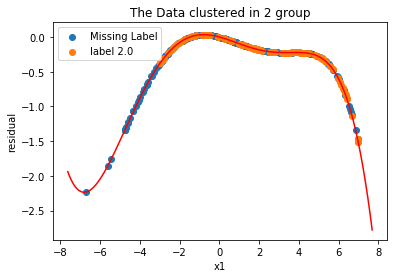

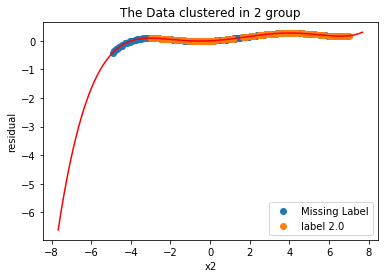

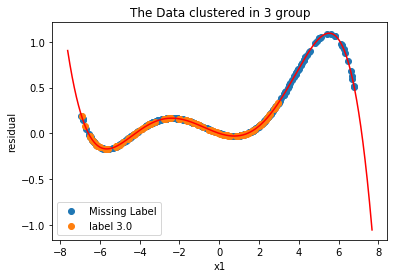

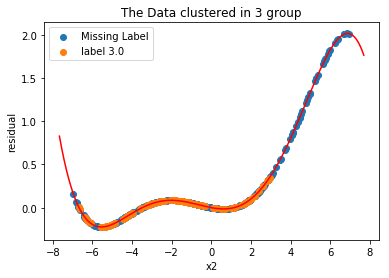

In [18]:
#  Train on simulated data

beta, Z, log_lambda,alpha,likelihood,W = Optimization(simX,simX_,simY, simLabels, 40,0.2)
optimized_params = (beta, Z, log_lambda,alpha,simX,simX_, simY, simLabels)


In [19]:


# Save to local
with open("optimized_params", "wb") as handle:
    pickle.dump(optimized_params,handle, protocol=pickle.HIGHEST_PROTOCOL)
with open("optimized_params", "rb") as handle:
    optimized_params = pickle.load(handle)

beta, Z, log_lambda,alpha,simX,simX_, simY, simLabels = optimized_params



In [20]:
def Clustering_Accuracy(Z,ans,labels):
    
    # get predicted labels
    pred = np.argmax(Z,axis=1)+1
    
    # compute accuracy of missing
    #accu = np.mean(pred[np.where(labels == 0)[0]]==ans[np.where(labels == 0)[0]])
    accu = np.mean(pred==ans) 
    
    return accu

Clustering_Accuracy(Z,ans,simLabels)

0.729